In [ ]:
!pip install langchain_community
!pip install langchain
!pip install datasets
!pip install faiss-gpu
!pip install sentence-transformers

In [93]:
import warnings
import torch
import pandas as pd
import faiss
import numpy as np
import tqdm
from PIL import Image
from tqdm.auto import tqdm
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode
from langchain_community.embeddings import HuggingFaceEmbeddings
from datasets import load_dataset
from langchain.embeddings import FakeEmbeddings
warnings.filterwarnings("ignore")

In [147]:
fashion_product_dataset = load_dataset("ashraq/fashion-product-images-small",
                                       split="train")
images = fashion_product_dataset['image']

fashion_product_dataset = fashion_product_dataset.remove_columns('image')
fashion_product_dataset = fashion_product_dataset.to_pandas()
#fashion_product_dataset = fashion_product_dataset.drop_duplicates(subset=["productDisplayName"], keep="first")
fashion_product_dataset.head()
print("---"*15)
print(len(fashion_product_dataset))

---------------------------------------------
44072


In [ ]:
images = fashion_product_dataset['image']

fashion_product_dataset = fashion_product_dataset.remove_columns('image')
fashion_product_dataset = fashion_product_dataset.to_pandas()
fashion_product_dataset = fashion_product_dataset.drop_duplicates(subset=["productDisplayName"], keep="first")
fashion_product_dataset.head()
print("---"*15)
print(len(fashion_product_dataset))

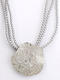

In [149]:
images[305]

In [150]:
BATCH_SIZE = 120
MODEL_NAME = "all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name="MODEL_NAME")
#embeddings = FakeEmbeddings(size=512)
embedding_list = []

In [ ]:
product_display_names = fashion_product_dataset["productDisplayName"]
for i in tqdm(range(0, len(product_display_names), BATCH_SIZE)):

    batch_names = product_display_names[i:i+BATCH_SIZE]
    batch_embeddings = embeddings.embed_documents(batch_names)
    embedding_list.extend(batch_embeddings)

product_embeddings = np.array(embedding_list).astype("float32")

In [152]:
n, d = product_embeddings.shape
print(f"Number of vectors: {n}")
print(f"Dimension of each vector: {d}")

Number of vectors: 44072
Dimension of each vector: 384


In [153]:
index = faiss.IndexFlatL2(d)
index.add(product_embeddings)

In [154]:
query = input("Search a product name: ")
query_embedding = embeddings.embed_query(query)
query_embedding = np.array([query_embedding]).astype("float32")

Search a product name: jean black women


In [155]:
k = 10
distances, indices = index.search(query_embedding, k)
print(distances, indices)

[[0.54685634 0.54685646 0.550064   0.550064   0.57724    0.62353987
  0.6458083  0.6478094  0.64780957 0.64780957]] [[31102  7213  6652 29052 38568 27241 35173  5233 40382 40089]]


In [157]:
flat_indices = [index for sublist in indices for index in sublist]
product_display_names = np.array(fashion_product_dataset["productDisplayName"])
for name in product_display_names[flat_indices]:
    print(name)

Elle Women Black Jeans
Elle Women Black Jeans
French Connection Women Black Jeans
French Connection Women Black Jeans
Denizen Women Black Jeans
ONLY Women Black Jeans
Pepe Jeans Women Black Jeans
Lee Women Black Jeans
Lee Women Black Jeans
Lee Women Black Jeans


In [158]:
faiss.write_index(index, "fashion_embeddings")
#index = faiss.read_index("my_index")


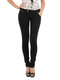
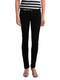
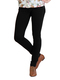
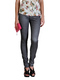
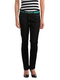
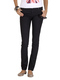
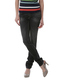
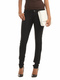
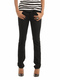
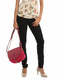

In [159]:
closest_images = [images[i] for i in flat_indices]

def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

display_result(closest_images)
